INFO:ml_toolbox.data_loader.data_loader:Loading 3 files with 1 workers
INFO:ml_toolbox.data_loader.data_loader:Successfully loaded 3 files
INFO:ml_toolbox.data_loader.data_loader:Successfully loaded 3 files


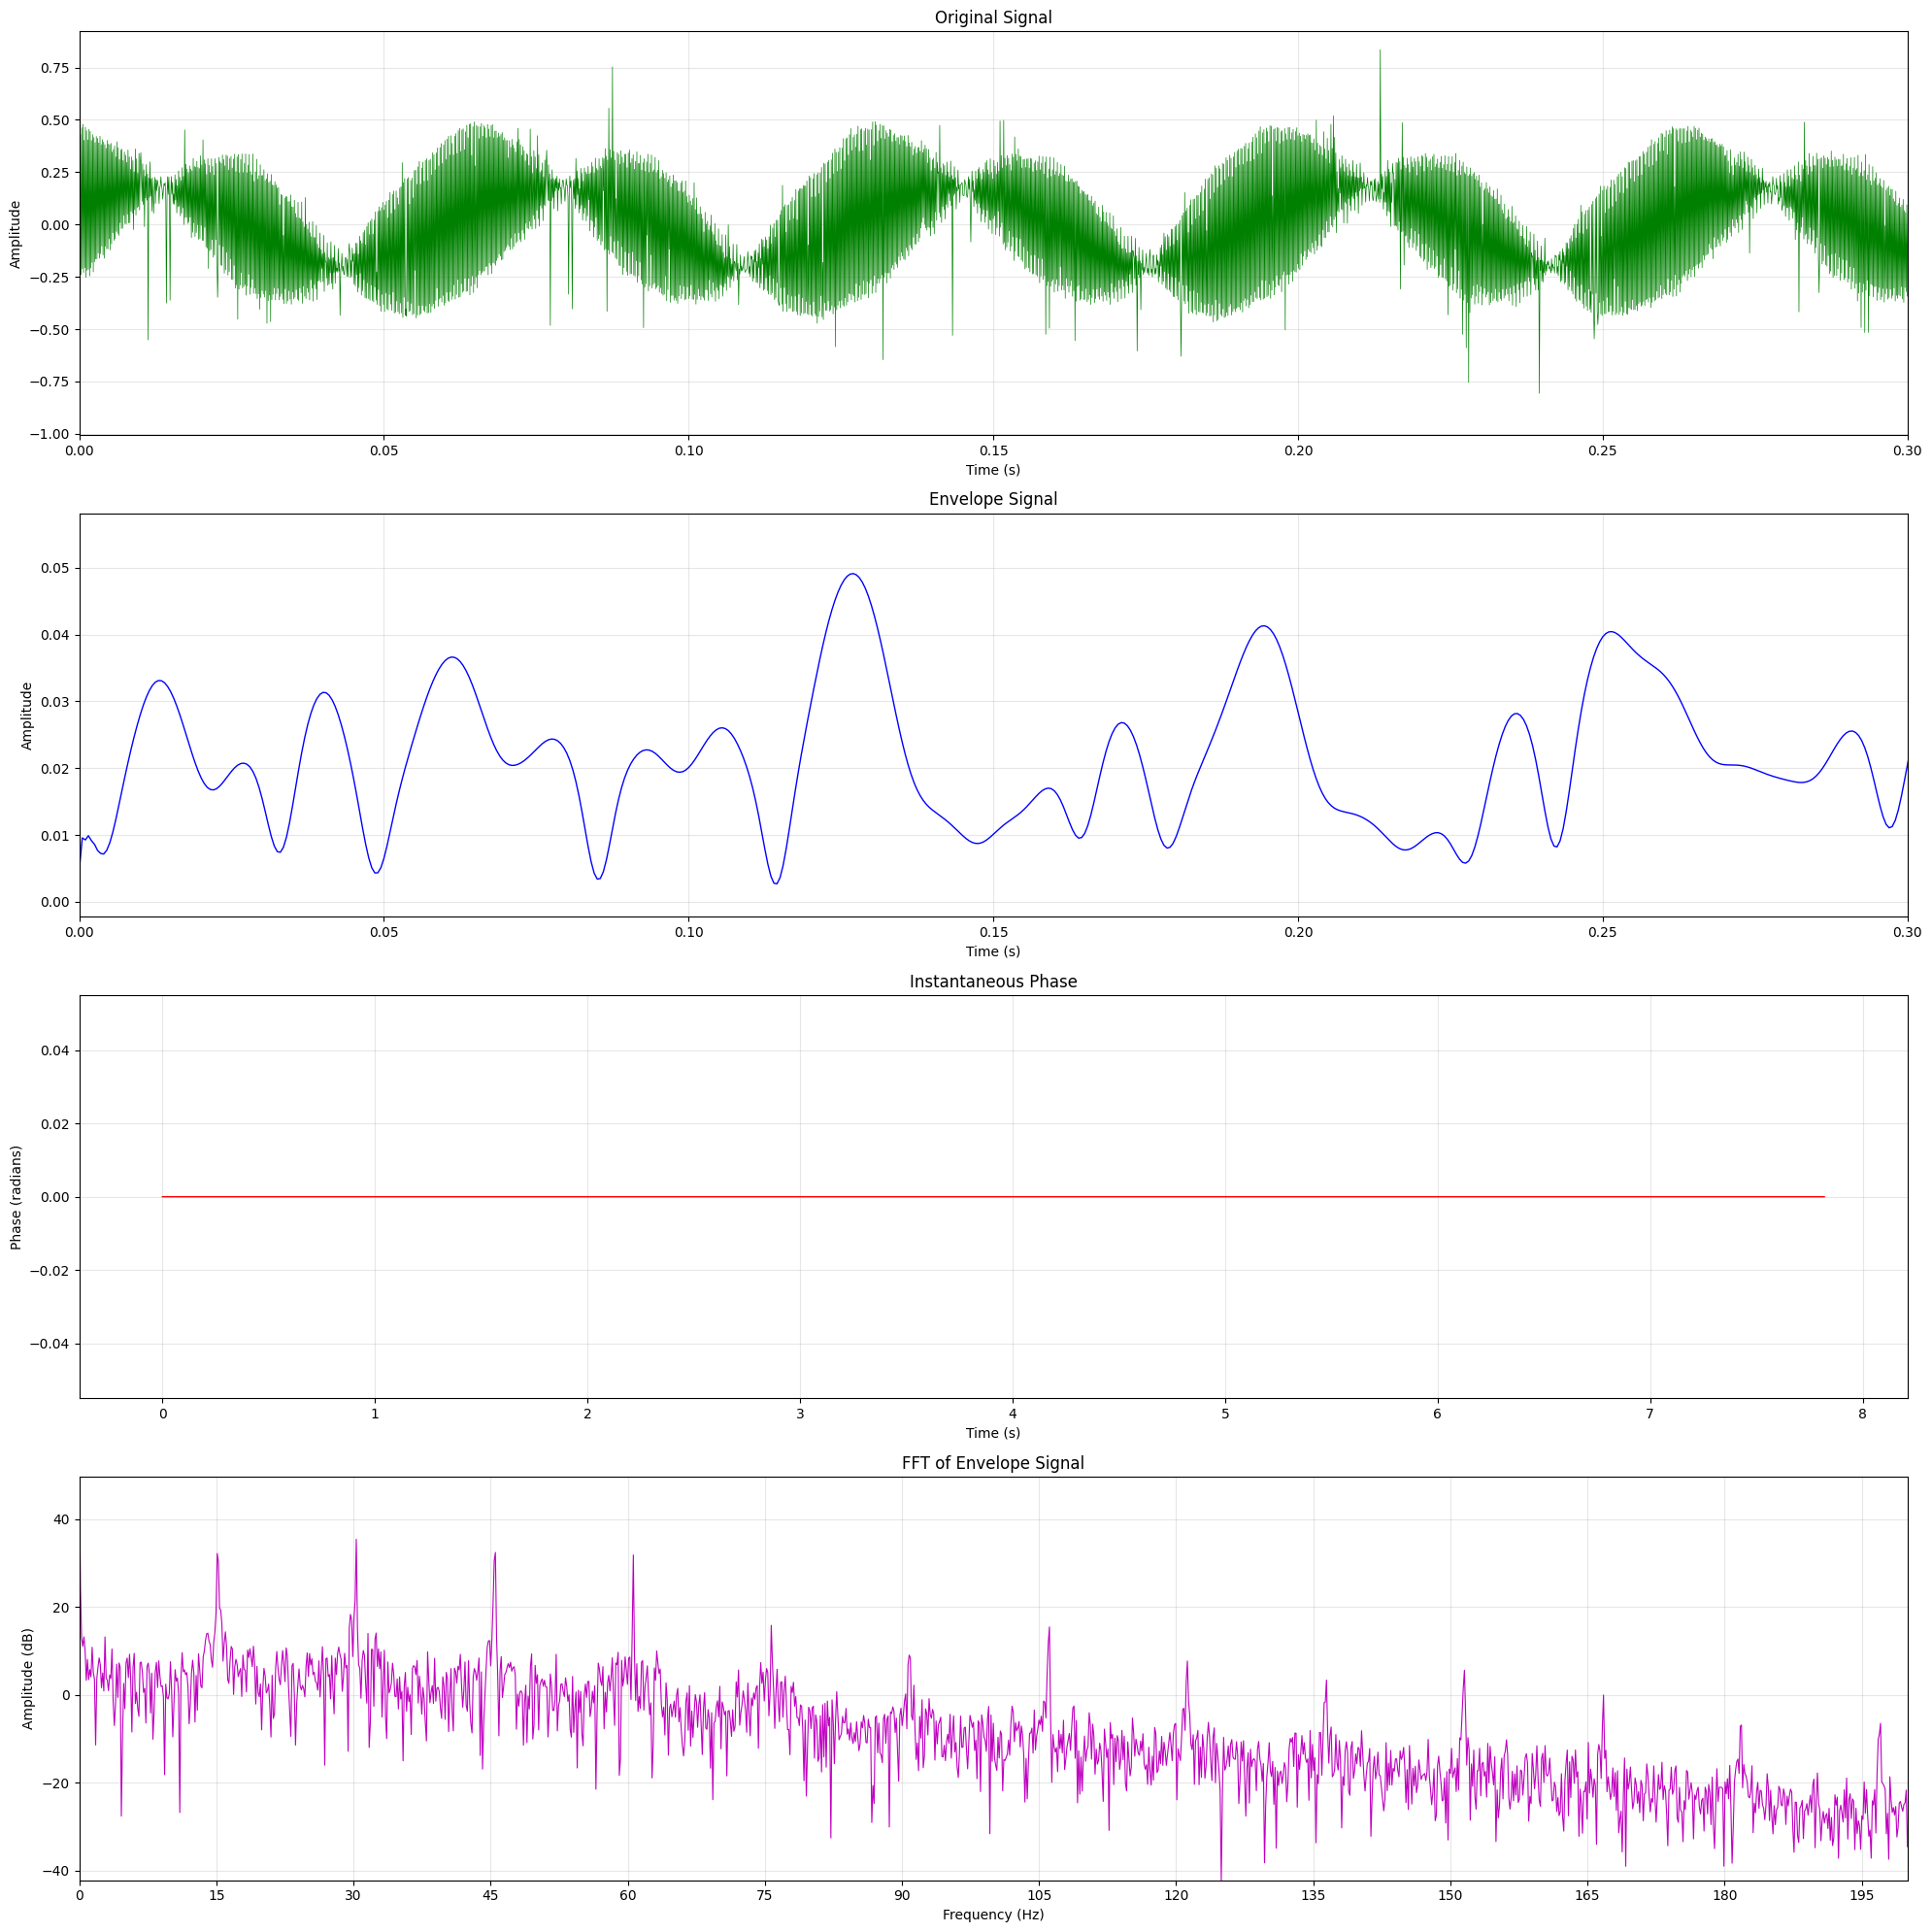

Original sampling frequency: 10000 Hz
Envelope sampling frequency: 2000.0 Hz
Signal duration: 7.82 seconds
Original signal range: -0.9177 to 0.8349
Envelope amplitude range: 0.0005 to 0.0554
Phase range: 0.00 to 0.00 radians

Top 5 peak frequencies in envelope FFT:
  0.00 Hz: 49.71 dB
  30.31 Hz: 35.47 dB
  45.52 Hz: 32.47 dB
  15.09 Hz: 32.23 dB
  60.61 Hz: 31.90 dB


In [1]:
import sys
import pandas as pd
from pathlib import Path
project_root = Path("..").resolve()
sys.path.append(str(project_root))
from ml_toolbox import HilbertEnvelopeAnalyzer, EnvelopeConfig, DataLoader, WindowConfig, WindowExtractor


# Load data and create windows
dataset_path = Path("../data_set")
data_loader = DataLoader(dataset_path)

frequency = '30hz'
sensor_type = 'current'
load = 'no_load'
sampling_rate = 10000

healthy, healthy_metadata = data_loader.load_batch(
    condition='misalignment', 
    load=load, 
    sensor_type=sensor_type, 
    frequency=frequency,
    apply_filter=False,
    max_workers=1
)
n_idx = 0
n_healthy = int (healthy[n_idx].shape[0] / 1)

# Create windows
overlap_ratio = 0.5
healthy_step_size = int(n_healthy * (1 - overlap_ratio))
healthy_window_config = WindowConfig(window_size=n_healthy, 
                             step_size=healthy_step_size,
                             overlap_ratio=overlap_ratio)
healthy_extractor = WindowExtractor(healthy_window_config)
healthy_windows, healthy_win_metadata = healthy_extractor.extract_windows(healthy[n_idx], healthy_metadata[n_idx])

h_w = healthy_windows[0]
h_ch1 = h_w[:, 0]
h_ch2 = h_w[:, 1]

# carrier freqs: 1670, 3330
carrier_freq = 3330
env_conf = EnvelopeConfig(
    bandpass_low=carrier_freq - 50,
    bandpass_high=carrier_freq + 50,
    lowpass_cutoff=200.0,
    filter_order=4,
    decimation_factor=5,
    sampling_rate=10000 # current fs
)

analyzer = HilbertEnvelopeAnalyzer(env_conf)

stages = analyzer.extract_envelope_with_stages(h_ch1, return_stages=True)

import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq

fig, axs = plt.subplots(4, 1, figsize=(20, 20))

orig = stages['original']
from scipy.signal import hilbert
env = stages['envelope_decimated']
inst_phase = np.unwrap(np.angle(env))

ts_orig = env_conf.sampling_rate
ts_env = env_conf.envelope_fs
t_orig = np.arange(len(orig)) / ts_orig
t_env = np.arange(len(env)) / ts_env

# Plot original signal
axs[0].plot(t_orig, orig, 'g-', linewidth=0.5)
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Amplitude')
axs[0].set_title('Original Signal')
axs[0].set_xlim([0, 0.3])
axs[0].grid(True, alpha=0.3)

# Plot envelope
axs[1].plot(t_env, env, 'b-', linewidth=1)
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Amplitude')
axs[1].set_title('Envelope Signal')
axs[1].set_xlim([0, 0.3])
axs[1].grid(True, alpha=0.3)

# Plot instantaneous phase
axs[2].plot(t_env, inst_phase, 'r-', linewidth=1)
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Phase (radians)')
axs[2].set_title('Instantaneous Phase')
axs[2].grid(True, alpha=0.3)

# Compute and plot FFT of envelope
fft_env = fft(np.abs(env))
freqs_env = fftfreq(len(env), 1/ts_env)

# Get positive frequencies only
positive_freq_idx = freqs_env >= 0
freqs_env_pos = freqs_env[positive_freq_idx]
fft_env_pos = np.abs(fft_env[positive_freq_idx])

# Convert to dB
fft_env_db = 20 * np.log10(fft_env_pos + 1e-10)

# Plot FFT of envelope
xlim_env = 200
xlim_mask = freqs_env_pos <= xlim_env
freqs_env_cropped = freqs_env_pos[xlim_mask]
fft_env_cropped = fft_env_db[xlim_mask]

axs[3].plot(freqs_env_cropped, fft_env_cropped, 'm-', linewidth=0.8)
axs[3].set_xlabel('Frequency (Hz)')
axs[3].set_ylabel('Amplitude (dB)')
axs[3].set_title('FFT of Envelope Signal')
axs[3].grid(True, alpha=0.3)
axs[3].set_xlim(0, xlim_env)
axs[3].set_ylim(min(fft_env_cropped), max(fft_env_cropped))
axs[3].set_xticks(np.arange(0, xlim_env + 1, 15))

plt.tight_layout()
plt.show()

# Print some basic info
print(f"Original sampling frequency: {ts_orig} Hz")
print(f"Envelope sampling frequency: {ts_env} Hz")
print(f"Signal duration: {len(env)/ts_env:.2f} seconds")
print(f"Original signal range: {np.min(orig):.4f} to {np.max(orig):.4f}")
print(f"Envelope amplitude range: {np.min(np.abs(env)):.4f} to {np.max(np.abs(env)):.4f}")
print(f"Phase range: {np.min(inst_phase):.2f} to {np.max(inst_phase):.2f} radians")

# Print peak frequencies in envelope FFT
print("\nTop 5 peak frequencies in envelope FFT:")
peak_indices = np.argsort(fft_env_pos)[-5:][::-1]
for idx in peak_indices:
    print(f"  {freqs_env_pos[idx]:.2f} Hz: {fft_env_db[idx]:.2f} dB")

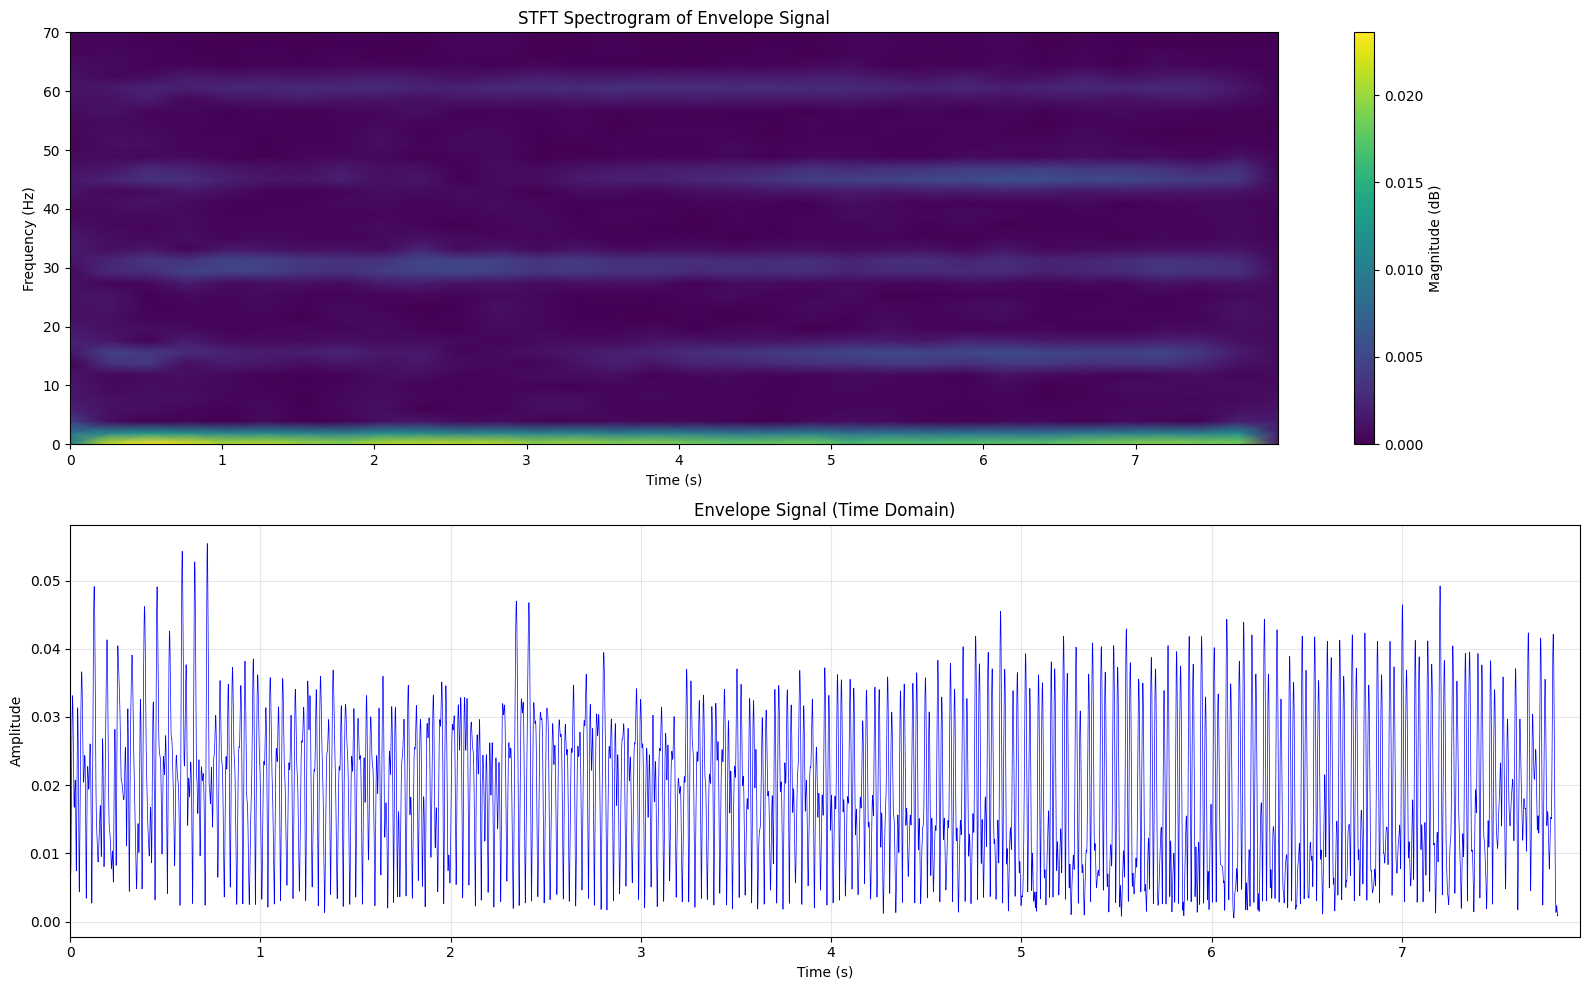

STFT Parameters:
  Window length (nperseg): 1024
  Overlap: 512 samples (50%)
  Frequency resolution: 1.95 Hz
  Time resolution: 0.2560 s
  Frequency range: 0.00 to 1000.00 Hz
  Time range: 0.0000 to 7.9360 s


In [2]:
# STFT Analysis of Envelope Signal
from scipy.signal import stft
import matplotlib.pyplot as plt
import numpy as np

# Compute STFT of the envelope
# Using shorter window for better time resolution in envelope analysis
nperseg = 1024  # Window length
noverlap = nperseg // 2  # 50% overlap

f_stft, t_stft, Zxx = stft(np.abs(env), fs=ts_env, nperseg=nperseg, noverlap=noverlap)

# Convert to dB scale
Zxx_db = 20 * np.log10(np.abs(Zxx) + 1e-10)

# Create figure with STFT spectrogram
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

# Plot 1: Spectrogram
pcm = ax1.pcolormesh(t_stft, f_stft, np.abs(Zxx), shading='gouraud', cmap='viridis')
ax1.set_ylabel('Frequency (Hz)')
ax1.set_xlabel('Time (s)')
ax1.set_title('STFT Spectrogram of Envelope Signal')
ax1.set_ylim(0, 70)  # Focus on 0-60 Hz range
fig.colorbar(pcm, ax=ax1, label='Magnitude (dB)')

# Plot 2: Time-domain envelope for reference
ax2.plot(t_env, np.abs(env), 'b-', linewidth=0.5)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Amplitude')
ax2.set_title('Envelope Signal (Time Domain)')
ax2.set_xlim(t_stft[0], t_stft[-1])
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"STFT Parameters:")
print(f"  Window length (nperseg): {nperseg}")
print(f"  Overlap: {noverlap} samples ({100*noverlap/nperseg:.0f}%)")
print(f"  Frequency resolution: {f_stft[1] - f_stft[0]:.2f} Hz")
print(f"  Time resolution: {t_stft[1] - t_stft[0]:.4f} s")
print(f"  Frequency range: {f_stft[0]:.2f} to {f_stft[-1]:.2f} Hz")
print(f"  Time range: {t_stft[0]:.4f} to {t_stft[-1]:.4f} s")

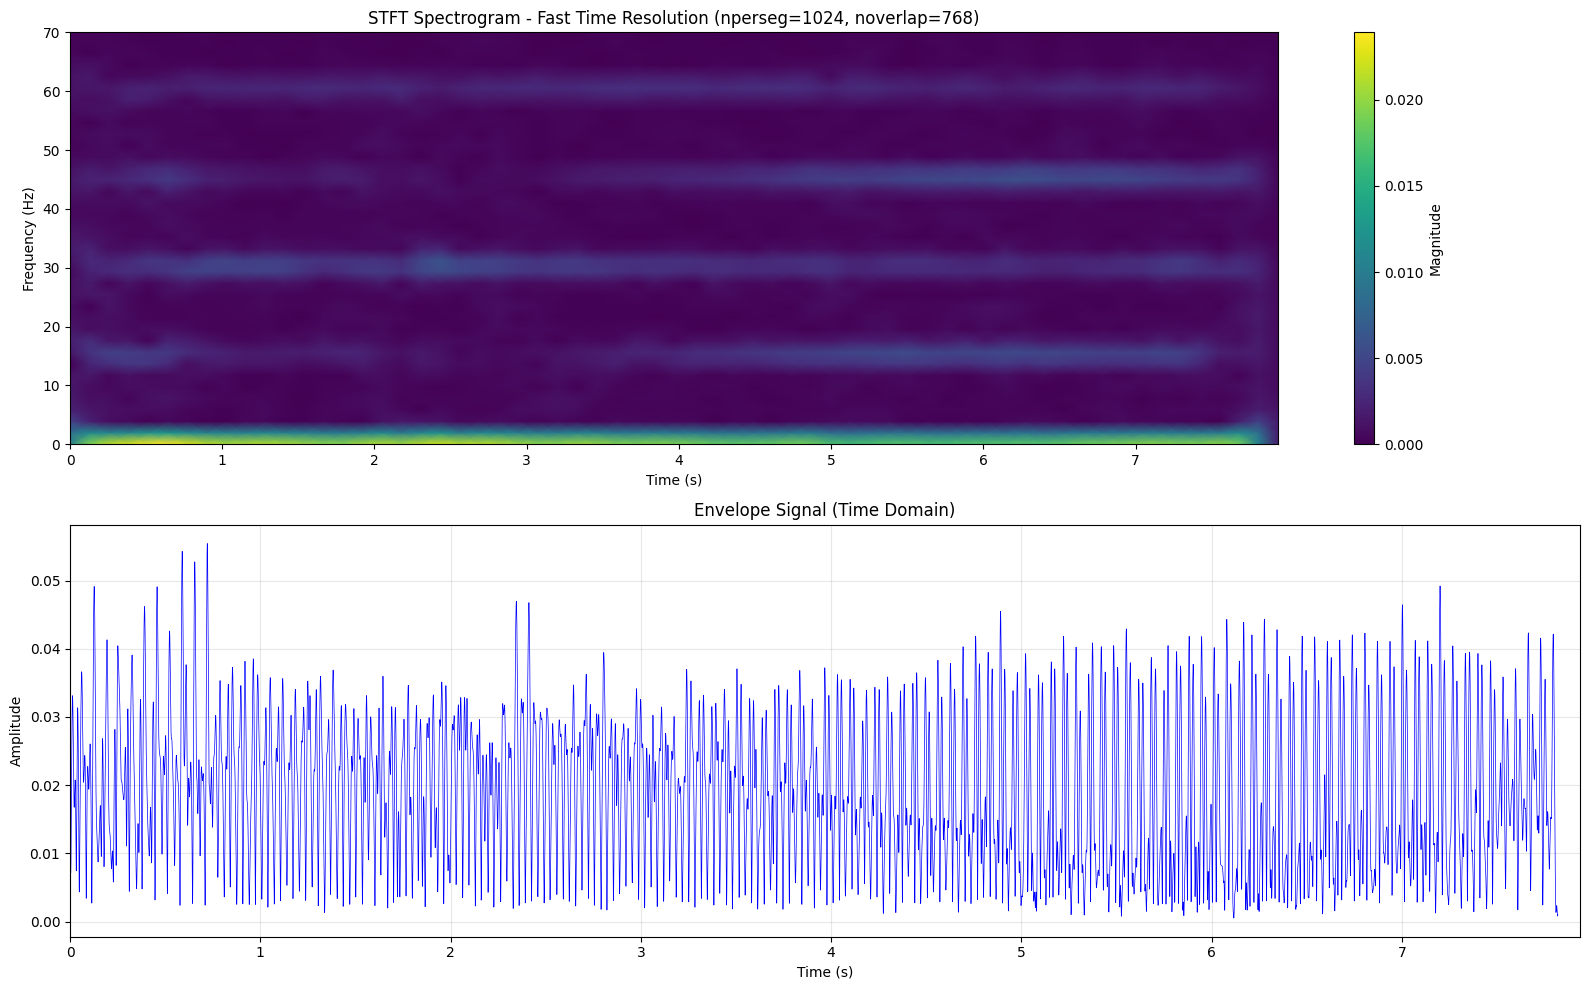

STFT Parameters (Fast Time Resolution):
  Window length (nperseg): 1024
  Overlap: 768 samples (75%)
  Frequency resolution: 1.9531 Hz
  Time resolution: 0.128000 s
  Frequency range: 0.00 to 1000.00 Hz
  Time range: 0.0000 to 7.9360 s


In [3]:
# STFT Analysis with Fast Time Resolution (nperseg=1024, noverlap=768)
from scipy.signal import stft
import matplotlib.pyplot as plt
import numpy as np

# STFT with fast time resolution (75% overlap)
nperseg_fast = 1024
noverlap_fast = 768

f_stft_fast, t_stft_fast, Zxx_fast = stft(np.abs(env), fs=ts_env, nperseg=nperseg_fast, noverlap=noverlap_fast)

# Convert to dB scale
Zxx_fast_db = 20 * np.log10(np.abs(Zxx_fast) + 1e-10)

# Create figure with STFT spectrogram
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

# Plot 1: Spectrogram
pcm = ax1.pcolormesh(t_stft_fast, f_stft_fast, np.abs(Zxx_fast), shading='gouraud', cmap='viridis')
ax1.set_ylabel('Frequency (Hz)')
ax1.set_xlabel('Time (s)')
ax1.set_title(f'STFT Spectrogram - Fast Time Resolution (nperseg={nperseg_fast}, noverlap={noverlap_fast})')
ax1.set_ylim(0, 70)
fig.colorbar(pcm, ax=ax1, label='Magnitude')

# Plot 2: Time-domain envelope for reference
ax2.plot(t_env, np.abs(env), 'b-', linewidth=0.5)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Amplitude')
ax2.set_title('Envelope Signal (Time Domain)')
ax2.set_xlim(t_stft_fast[0], t_stft_fast[-1])
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"STFT Parameters (Fast Time Resolution):")
print(f"  Window length (nperseg): {nperseg_fast}")
print(f"  Overlap: {noverlap_fast} samples ({100*noverlap_fast/nperseg_fast:.0f}%)")
print(f"  Frequency resolution: {f_stft_fast[1] - f_stft_fast[0]:.4f} Hz")
print(f"  Time resolution: {t_stft_fast[1] - t_stft_fast[0]:.6f} s")
print(f"  Frequency range: {f_stft_fast[0]:.2f} to {f_stft_fast[-1]:.2f} Hz")
print(f"  Time range: {t_stft_fast[0]:.4f} to {t_stft_fast[-1]:.4f} s")

d:\code\ml\health-asyn-ml\venv\Lib\site-packages\scipy\signal\_spectral_py.py:1595: UserWarning: nperseg = 16384 is greater than input length  = 15640, using nperseg = 15640
  freqs, time, Zxx = _spectral_helper(x, x, fs, window, nperseg, noverlap,


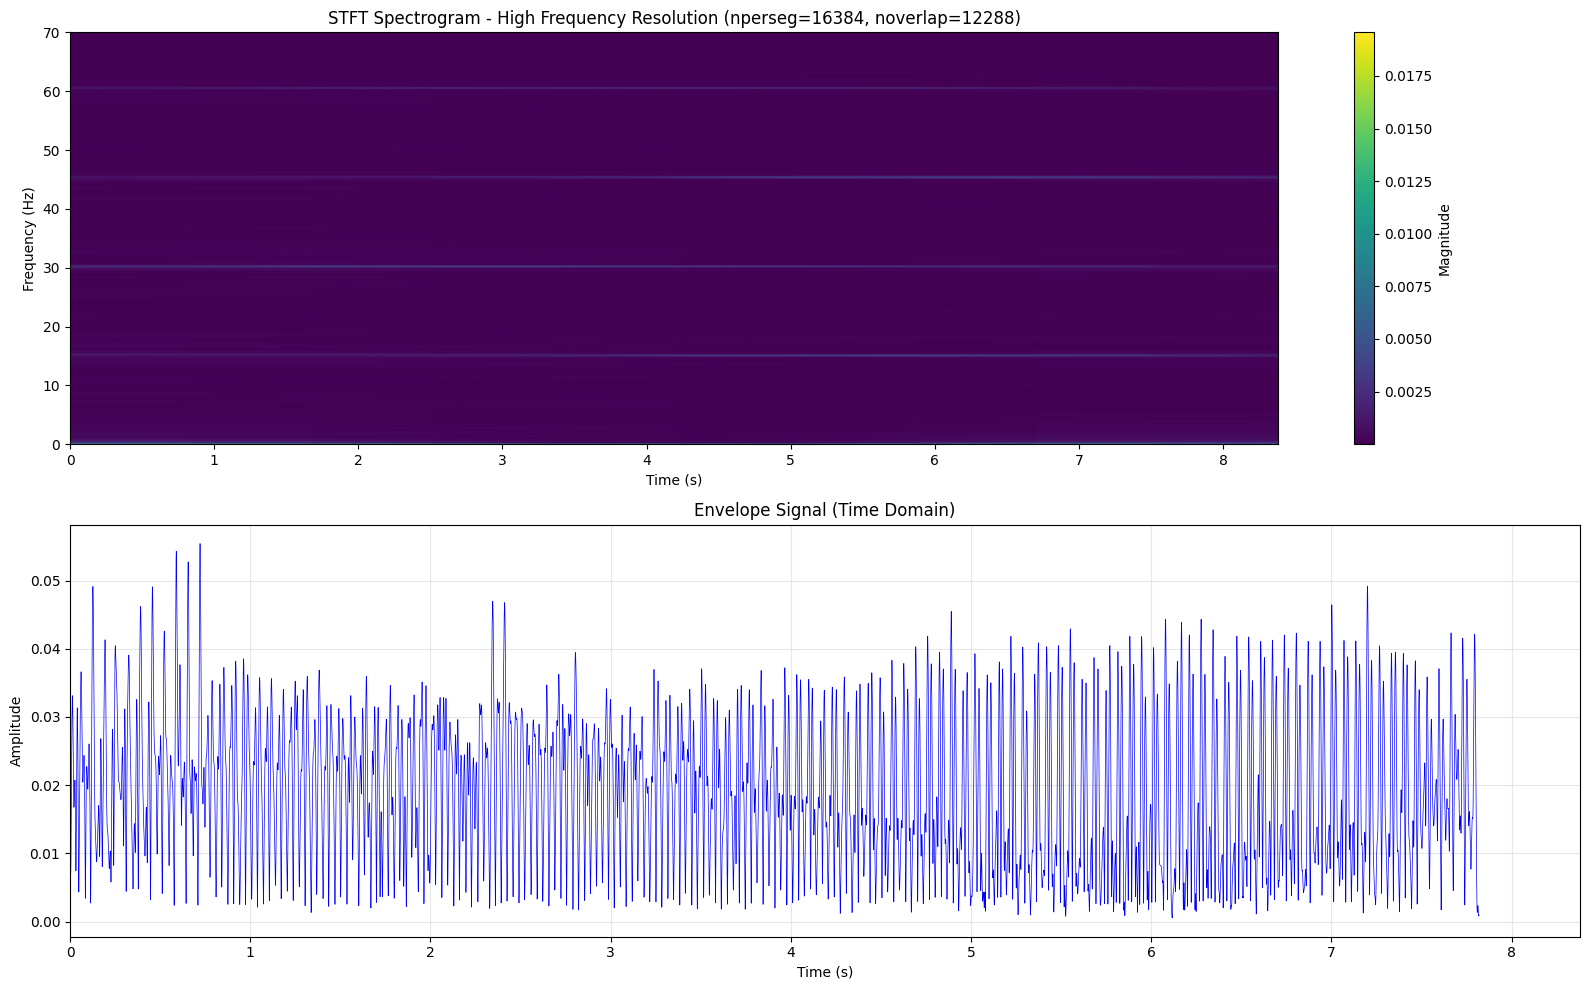

STFT Parameters (High Frequency Resolution):
  Window length (nperseg): 16384
  Overlap: 12288 samples (75%)
  Frequency resolution: 0.127877 Hz
  Time resolution: 1.676000 s
  Frequency range: 0.00 to 1000.00 Hz
  Time range: 0.0000 to 8.3800 s


In [4]:
# STFT Analysis with High Frequency Resolution (nperseg=16384, noverlap=12288)
from scipy.signal import stft
import matplotlib.pyplot as plt
import numpy as np

# STFT with high frequency resolution (75% overlap)
nperseg_hf = 16384
noverlap_hf = 12288

f_stft_hf, t_stft_hf, Zxx_hf = stft(np.abs(env), fs=ts_env, nperseg=nperseg_hf, noverlap=noverlap_hf)

# Convert to dB scale
Zxx_hf_db = 20 * np.log10(np.abs(Zxx_hf) + 1e-10)

# Create figure with STFT spectrogram
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

# Plot 1: Spectrogram
pcm = ax1.pcolormesh(t_stft_hf, f_stft_hf, np.abs(Zxx_hf), shading='gouraud', cmap='viridis')
ax1.set_ylabel('Frequency (Hz)')
ax1.set_xlabel('Time (s)')
ax1.set_title(f'STFT Spectrogram - High Frequency Resolution (nperseg={nperseg_hf}, noverlap={noverlap_hf})')
ax1.set_ylim(0, 70)
fig.colorbar(pcm, ax=ax1, label='Magnitude')

# Plot 2: Time-domain envelope for reference
ax2.plot(t_env, np.abs(env), 'b-', linewidth=0.5)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Amplitude')
ax2.set_title('Envelope Signal (Time Domain)')
ax2.set_xlim(t_stft_hf[0], t_stft_hf[-1])
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"STFT Parameters (High Frequency Resolution):")
print(f"  Window length (nperseg): {nperseg_hf}")
print(f"  Overlap: {noverlap_hf} samples ({100*noverlap_hf/nperseg_hf:.0f}%)")
print(f"  Frequency resolution: {f_stft_hf[1] - f_stft_hf[0]:.6f} Hz")
print(f"  Time resolution: {t_stft_hf[1] - t_stft_hf[0]:.6f} s")
print(f"  Frequency range: {f_stft_hf[0]:.2f} to {f_stft_hf[-1]:.2f} Hz")
print(f"  Time range: {t_stft_hf[0]:.4f} to {t_stft_hf[-1]:.4f} s")

Envelope signal length: 15640 samples (7.82 seconds)
Window size: 4000 samples (2.00 seconds)
Step size: 1000 samples
Overlap: 75%
Number of envelope windows: 12

Phase Coherence Analysis

15 Hz:
  Mean phase: 0.3282 rad (18.80°)
  Std phase:  1.7890 rad (102.50°)
  Min phase:  -2.9917 rad (-171.41°)
  Max phase:  3.1022 rad (177.74°)
  Range:      6.0939 rad (349.15°)

30 Hz:
  Mean phase: 0.0924 rad (5.29°)
  Std phase:  1.8837 rad (107.93°)
  Min phase:  -2.4763 rad (-141.88°)
  Max phase:  2.9153 rad (167.03°)
  Range:      5.3916 rad (308.91°)

Phase Coherence Comparison
std(phase_15) / std(phase_30) = 1.7890 / 1.8837 = 0.95

✗ Both frequencies show similar or 30 Hz has higher phase variability


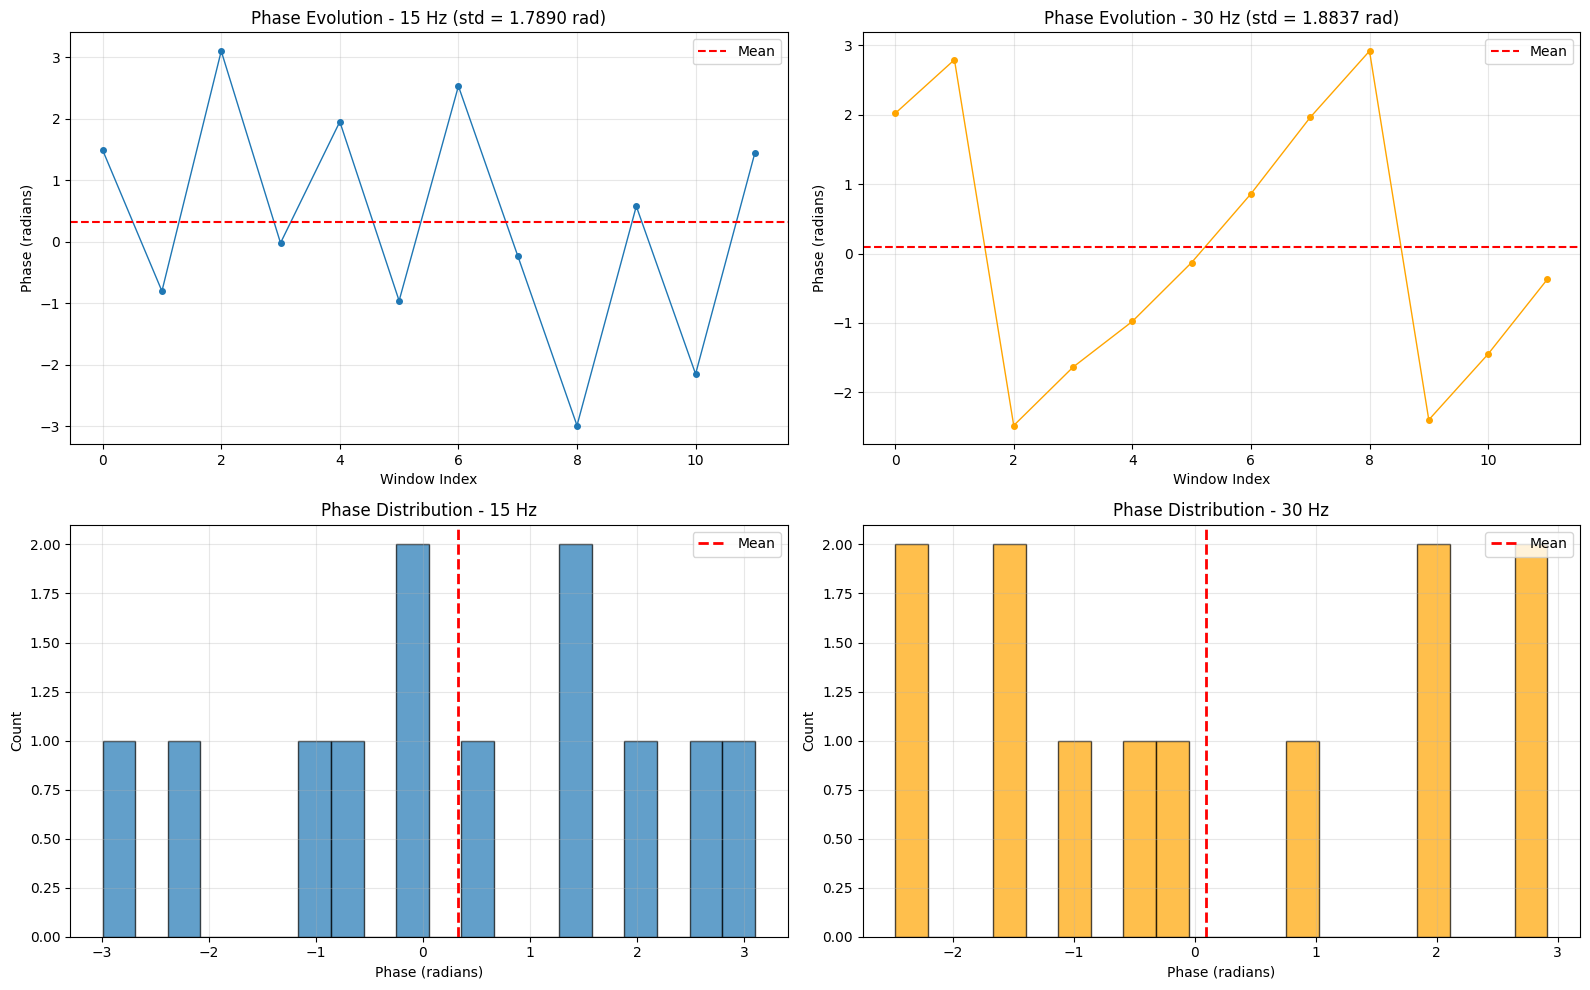

In [5]:
# Phase Coherence Analysis for 15 Hz and 30 Hz across windows
import numpy as np
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt

# Create multiple windows from envelope signal for phase analysis
n_env = len(env)

# Use a reasonable window size for envelope analysis
# For 15 Hz, we need at least several cycles: use 2 seconds window
window_duration = 2.0  # seconds
window_size = int(window_duration * ts_env)
overlap_ratio = 0.75  # 75% overlap for good coverage
step_size = int(window_size * (1 - overlap_ratio))

# Make sure window size is not larger than signal
if window_size > n_env:
    window_size = n_env // 2
    step_size = window_size // 4

print(f"Envelope signal length: {n_env} samples ({n_env/ts_env:.2f} seconds)")
print(f"Window size: {window_size} samples ({window_size/ts_env:.2f} seconds)")
print(f"Step size: {step_size} samples")
print(f"Overlap: {overlap_ratio*100:.0f}%")

# Extract windows from envelope
num_windows = (n_env - window_size) // step_size + 1
env_windows = []

for i in range(num_windows):
    start = i * step_size
    end = start + window_size
    if end <= n_env:
        env_windows.append(env[start:end])

print(f"Number of envelope windows: {len(env_windows)}")

# Check if we have any windows
if len(env_windows) == 0:
    print("\nERROR: No windows created! Signal too short or window too large.")
    print(f"Signal length: {n_env}, Window size: {window_size}")
else:
    # Target frequencies to analyze
    target_freqs_phase = [15, 30]
    
    # Storage for phase values
    phase_results = {freq: [] for freq in target_freqs_phase}
    
    # Analyze each window
    for i, window in enumerate(env_windows):
        # Compute FFT
        window_abs = np.abs(window)
        fft_result = fft(window_abs)
        freqs = fftfreq(len(window_abs), 1/ts_env)
        
        # Get positive frequencies
        positive_idx = freqs >= 0
        freqs_pos = freqs[positive_idx]
        fft_complex = fft_result[positive_idx]
        
        # Extract phase at target frequencies
        for target_freq in target_freqs_phase:
            # Find closest frequency bin
            freq_idx = np.argmin(np.abs(freqs_pos - target_freq))
            actual_freq = freqs_pos[freq_idx]
            
            # Get phase (in radians)
            phase = np.angle(fft_complex[freq_idx])
            phase_results[target_freq].append(phase)
    
    # Convert to arrays
    for freq in target_freqs_phase:
        phase_results[freq] = np.array(phase_results[freq])
    
    # Compute statistics
    print("\n" + "="*80)
    print("Phase Coherence Analysis")
    print("="*80)
    
    for freq in target_freqs_phase:
        phases = phase_results[freq]
        
        if len(phases) > 0:
            std_phase = np.std(phases)
            mean_phase = np.mean(phases)
            
            print(f"\n{freq} Hz:")
            print(f"  Mean phase: {mean_phase:.4f} rad ({np.degrees(mean_phase):.2f}°)")
            print(f"  Std phase:  {std_phase:.4f} rad ({np.degrees(std_phase):.2f}°)")
            print(f"  Min phase:  {np.min(phases):.4f} rad ({np.degrees(np.min(phases)):.2f}°)")
            print(f"  Max phase:  {np.max(phases):.4f} rad ({np.degrees(np.max(phases)):.2f}°)")
            print(f"  Range:      {np.max(phases) - np.min(phases):.4f} rad ({np.degrees(np.max(phases) - np.min(phases)):.2f}°)")
    
    # Compare coherence
    std_15 = np.std(phase_results[15])
    std_30 = np.std(phase_results[30])
    ratio = std_15 / std_30 if std_30 > 0 else np.inf
    
    print("\n" + "="*80)
    print("Phase Coherence Comparison")
    print("="*80)
    print(f"std(phase_15) / std(phase_30) = {std_15:.4f} / {std_30:.4f} = {ratio:.2f}")
    
    if std_15 > 2 * std_30:
        print(f"\n✓ std(phase_15) >> std(phase_30) - 15 Hz shows MUCH HIGHER phase variability!")
        print(f"  This suggests 15 Hz is NOT a stable frequency component in the signal.")
    elif std_15 > std_30:
        print(f"\n✓ std(phase_15) > std(phase_30) - 15 Hz shows higher phase variability")
        print(f"  This suggests 15 Hz has lower coherence than 30 Hz.")
    else:
        print(f"\n✗ Both frequencies show similar or 30 Hz has higher phase variability")
    
    # Visualize phase evolution across windows
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # Plot 1: Phase evolution for 15 Hz
    mean_phase_15 = np.mean(phase_results[15])
    axes[0, 0].plot(range(len(phase_results[15])), phase_results[15], 'o-', markersize=4, linewidth=1)
    axes[0, 0].set_xlabel('Window Index')
    axes[0, 0].set_ylabel('Phase (radians)')
    axes[0, 0].set_title(f'Phase Evolution - 15 Hz (std = {std_15:.4f} rad)')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].axhline(y=mean_phase_15, color='r', linestyle='--', label='Mean')
    axes[0, 0].legend()
    
    # Plot 2: Phase evolution for 30 Hz
    mean_phase_30 = np.mean(phase_results[30])
    axes[0, 1].plot(range(len(phase_results[30])), phase_results[30], 'o-', markersize=4, linewidth=1, color='orange')
    axes[0, 1].set_xlabel('Window Index')
    axes[0, 1].set_ylabel('Phase (radians)')
    axes[0, 1].set_title(f'Phase Evolution - 30 Hz (std = {std_30:.4f} rad)')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].axhline(y=mean_phase_30, color='r', linestyle='--', label='Mean')
    axes[0, 1].legend()
    
    # Plot 3: Phase histogram for 15 Hz
    axes[1, 0].hist(phase_results[15], bins=20, alpha=0.7, edgecolor='black')
    axes[1, 0].set_xlabel('Phase (radians)')
    axes[1, 0].set_ylabel('Count')
    axes[1, 0].set_title(f'Phase Distribution - 15 Hz')
    axes[1, 0].axvline(x=mean_phase_15, color='r', linestyle='--', linewidth=2, label='Mean')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].legend()
    
    # Plot 4: Phase histogram for 30 Hz
    axes[1, 1].hist(phase_results[30], bins=20, alpha=0.7, edgecolor='black', color='orange')
    axes[1, 1].set_xlabel('Phase (radians)')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].set_title(f'Phase Distribution - 30 Hz')
    axes[1, 1].axvline(x=mean_phase_30, color='r', linestyle='--', linewidth=2, label='Mean')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()

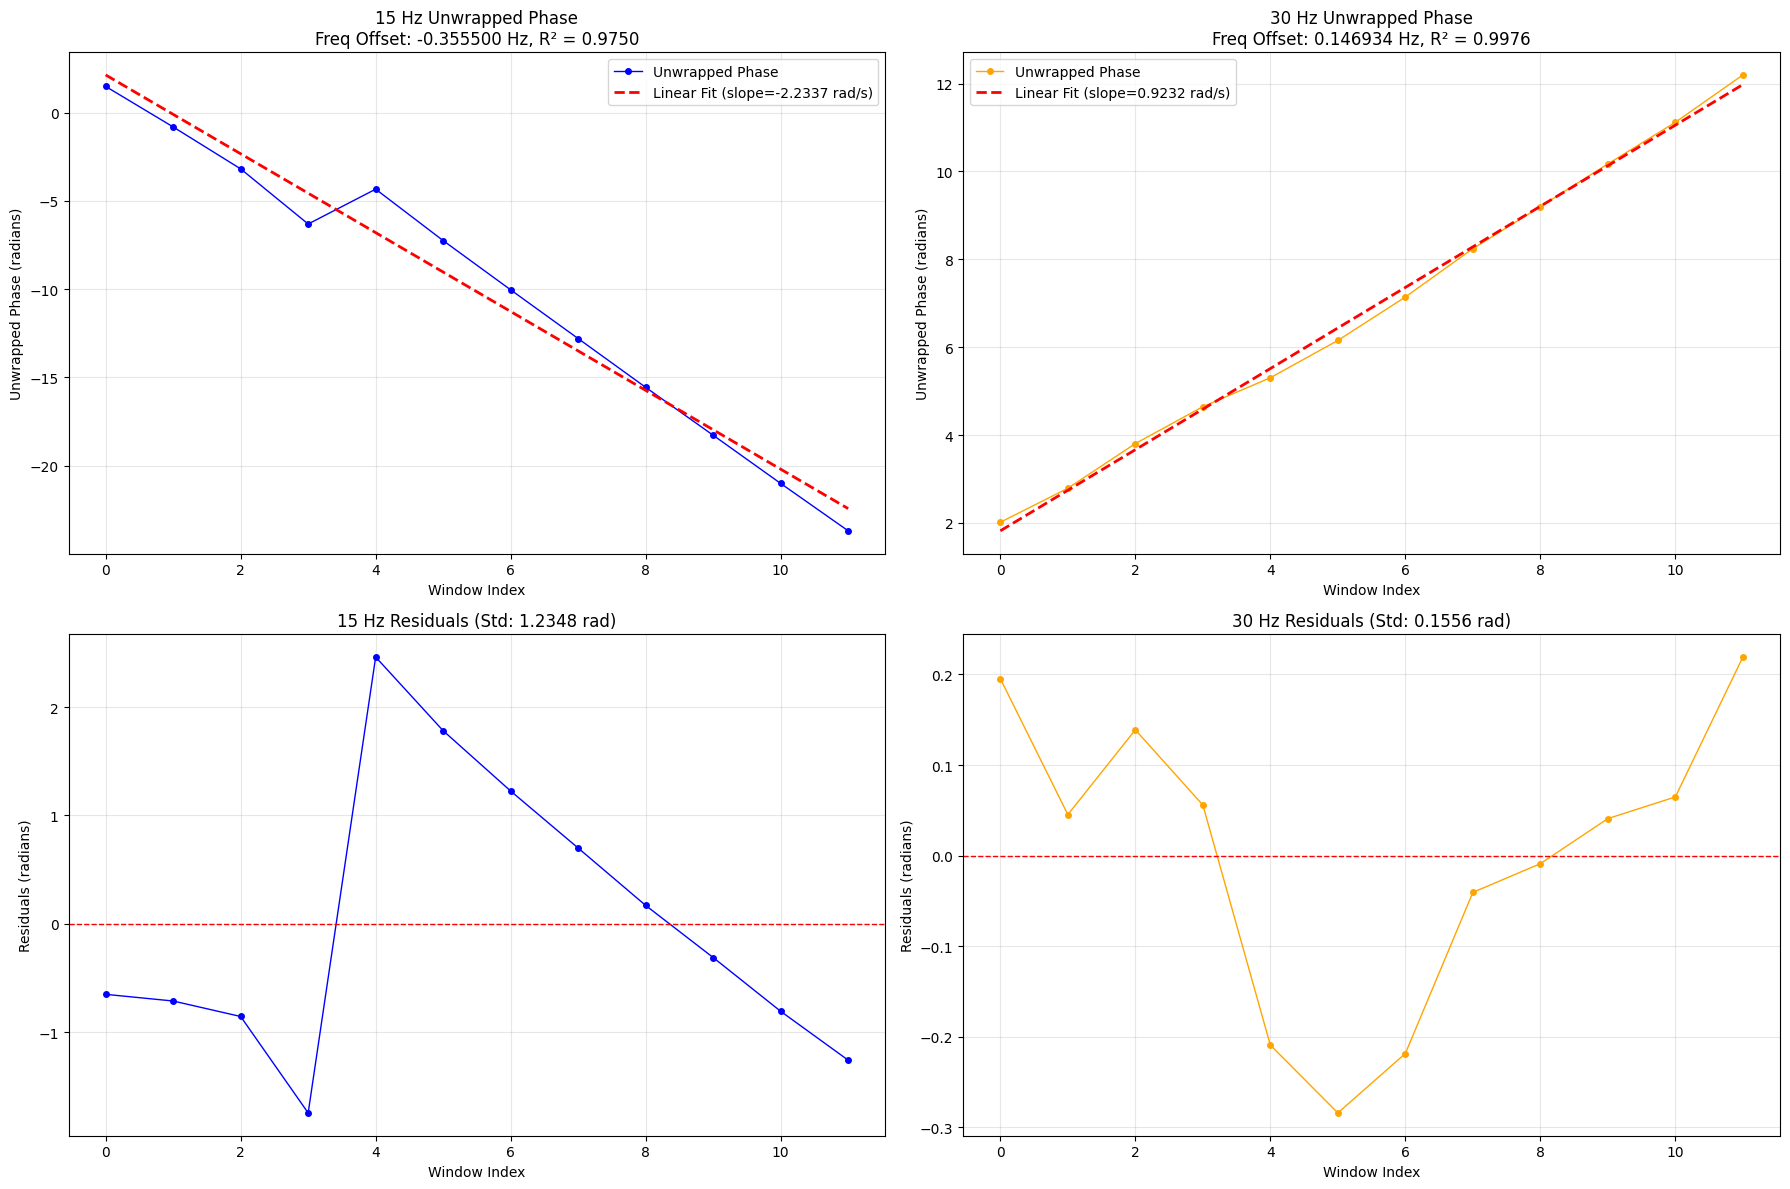

PHASE UNWRAPPING AND LINEAR REGRESSION ANALYSIS

Window step assumed: 1.0 second(s)
Number of windows analyzed: 12
Total time span: 11.0 seconds

--------------------------------------------------------------------------------
15 Hz Analysis:
--------------------------------------------------------------------------------
  Linear Fit Slope:           -2.233672 rad/s
  Linear Fit Intercept:       2.141427 rad
  R² (goodness of fit):       0.974996
  Standard Error:             0.014249
  
  Estimated Frequency Offset: -0.355500 Hz
  Phase Change per Window:    -2.233672 rad/window
  Freq Change per Window:     -0.355500 Hz/window
  Residual Std Dev:           1.234820 rad
  Residual Mean:              -5.181041e-16 rad (should be ~0)

--------------------------------------------------------------------------------
30 Hz Analysis:
--------------------------------------------------------------------------------
  Linear Fit Slope:           0.923216 rad/s
  Linear Fit Intercept:       1.

In [6]:
# Phase Unwrapping and Linear Regression Analysis
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Extract phase arrays (assuming they exist from previous cell)
ph15 = phase_results[15]
ph30 = phase_results[30]

# Step 1: Unwrap both phase arrays to remove ±π jumps
ph15_unwrapped = np.unwrap(ph15)
ph30_unwrapped = np.unwrap(ph30)

# Step 2: Create window indices
window_indices = np.arange(len(ph15))

# Assume constant window step of 1 second between phase samples
window_step_seconds = 1.0  # seconds
time_axis = window_indices * window_step_seconds

# Step 3: Fit linear regression to unwrapped 30 Hz phase
# Using scipy.stats.linregress for robust linear fit
slope_30, intercept_30, r_value_30, p_value_30, std_err_30 = stats.linregress(time_axis, ph30_unwrapped)

# Also fit for 15 Hz for comparison
slope_15, intercept_15, r_value_15, p_value_15, std_err_15 = stats.linregress(time_axis, ph15_unwrapped)

# Step 4: Convert slope to frequency offset
# f_offset = slope / (2 * π) in Hz
f_offset_30 = slope_30 / (2 * np.pi)
f_offset_15 = slope_15 / (2 * np.pi)

# Per-window phase difference in Hz (phase change per window / 2π)
phase_diff_per_window_30 = slope_30 / (2 * np.pi)  # Hz per window
phase_diff_per_window_15 = slope_15 / (2 * np.pi)  # Hz per window

# Generate fitted lines
fitted_line_30 = slope_30 * time_axis + intercept_30
fitted_line_15 = slope_15 * time_axis + intercept_15

# Step 5: Create visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: Unwrapped phase for 15 Hz
axes[0, 0].plot(window_indices, ph15_unwrapped, 'o-', markersize=4, linewidth=1, label='Unwrapped Phase', color='blue')
axes[0, 0].plot(window_indices, fitted_line_15, 'r--', linewidth=2, label=f'Linear Fit (slope={slope_15:.4f} rad/s)')
axes[0, 0].set_xlabel('Window Index')
axes[0, 0].set_ylabel('Unwrapped Phase (radians)')
axes[0, 0].set_title(f'15 Hz Unwrapped Phase\nFreq Offset: {f_offset_15:.6f} Hz, R² = {r_value_15**2:.4f}')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# Plot 2: Unwrapped phase for 30 Hz
axes[0, 1].plot(window_indices, ph30_unwrapped, 'o-', markersize=4, linewidth=1, label='Unwrapped Phase', color='orange')
axes[0, 1].plot(window_indices, fitted_line_30, 'r--', linewidth=2, label=f'Linear Fit (slope={slope_30:.4f} rad/s)')
axes[0, 1].set_xlabel('Window Index')
axes[0, 1].set_ylabel('Unwrapped Phase (radians)')
axes[0, 1].set_title(f'30 Hz Unwrapped Phase\nFreq Offset: {f_offset_30:.6f} Hz, R² = {r_value_30**2:.4f}')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

# Plot 3: Residuals for 15 Hz
residuals_15 = ph15_unwrapped - fitted_line_15
axes[1, 0].plot(window_indices, residuals_15, 'o-', markersize=4, linewidth=1, color='blue')
axes[1, 0].axhline(y=0, color='r', linestyle='--', linewidth=1)
axes[1, 0].set_xlabel('Window Index')
axes[1, 0].set_ylabel('Residuals (radians)')
axes[1, 0].set_title(f'15 Hz Residuals (Std: {np.std(residuals_15):.4f} rad)')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Residuals for 30 Hz
residuals_30 = ph30_unwrapped - fitted_line_30
axes[1, 1].plot(window_indices, residuals_30, 'o-', markersize=4, linewidth=1, color='orange')
axes[1, 1].axhline(y=0, color='r', linestyle='--', linewidth=1)
axes[1, 1].set_xlabel('Window Index')
axes[1, 1].set_ylabel('Residuals (radians)')
axes[1, 1].set_title(f'30 Hz Residuals (Std: {np.std(residuals_30):.4f} rad)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Step 6: Print detailed results
print("=" * 80)
print("PHASE UNWRAPPING AND LINEAR REGRESSION ANALYSIS")
print("=" * 80)
print(f"\nWindow step assumed: {window_step_seconds} second(s)")
print(f"Number of windows analyzed: {len(ph15)}")
print(f"Total time span: {time_axis[-1]} seconds")

print("\n" + "-" * 80)
print("15 Hz Analysis:")
print("-" * 80)
print(f"  Linear Fit Slope:           {slope_15:.6f} rad/s")
print(f"  Linear Fit Intercept:       {intercept_15:.6f} rad")
print(f"  R² (goodness of fit):       {r_value_15**2:.6f}")
print(f"  Standard Error:             {std_err_30:.6f}")
print(f"  ")
print(f"  Estimated Frequency Offset: {f_offset_15:.6f} Hz")
print(f"  Phase Change per Window:    {slope_15:.6f} rad/window")
print(f"  Freq Change per Window:     {phase_diff_per_window_15:.6f} Hz/window")
print(f"  Residual Std Dev:           {np.std(residuals_15):.6f} rad")
print(f"  Residual Mean:              {np.mean(residuals_15):.6e} rad (should be ~0)")

print("\n" + "-" * 80)
print("30 Hz Analysis:")
print("-" * 80)
print(f"  Linear Fit Slope:           {slope_30:.6f} rad/s")
print(f"  Linear Fit Intercept:       {intercept_30:.6f} rad")
print(f"  R² (goodness of fit):       {r_value_30**2:.6f}")
print(f"  Standard Error:             {std_err_30:.6f}")
print(f"  ")
print(f"  Estimated Frequency Offset: {f_offset_30:.6f} Hz")
print(f"  Phase Change per Window:    {slope_30:.6f} rad/window")
print(f"  Freq Change per Window:     {phase_diff_per_window_30:.6f} Hz/window")
print(f"  Residual Std Dev:           {np.std(residuals_30):.6f} rad")
print(f"  Residual Mean:              {np.mean(residuals_30):.6e} rad (should be ~0)")

print("\n" + "-" * 80)
print("Comparison:")
print("-" * 80)
print(f"  Ratio (Residual Std 15Hz / 30Hz): {np.std(residuals_15) / np.std(residuals_30):.2f}")
print(f"  Ratio (R² 30Hz / 15Hz):            {r_value_30**2 / r_value_15**2:.2f}")
print(f"  ")
if r_value_30**2 > r_value_15**2:
    print(f"  ✓ 30 Hz shows BETTER linear fit (higher R²)")
    print(f"    This suggests 30 Hz has more coherent phase evolution.")
else:
    print(f"  ✗ 15 Hz shows better or similar linear fit")
    
if np.std(residuals_30) < np.std(residuals_15):
    print(f"  ✓ 30 Hz shows LOWER residual variance")
    print(f"    This suggests 30 Hz is a more stable frequency component.")
else:
    print(f"  ✗ 15 Hz shows lower or similar residual variance")

print("=" * 80)

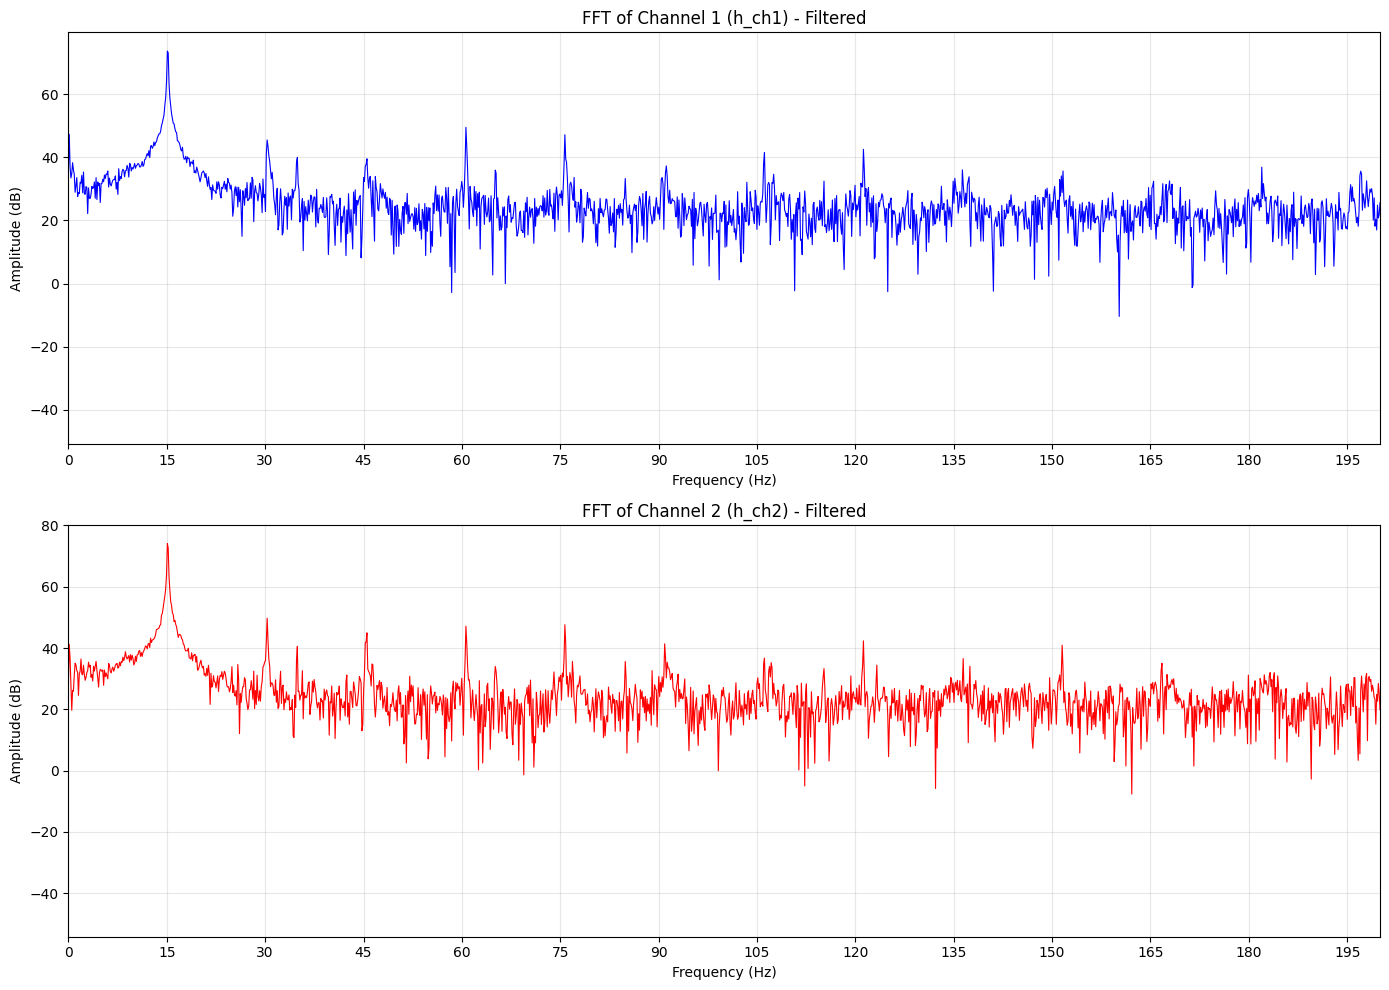


Amplitudes at specific frequencies:
Frequency (Hz)       Ch1 Amp (dB)              Ch2 Amp (dB)             
----------------------------------------------------------------------
30.05                22.84                     35.88                    
59.98                32.36                     30.11                    
90.03                24.23                     30.74                    
119.95               31.15                     23.78                    
150.00               25.83                     19.74                    
180.05               26.39                     19.29                    


In [7]:
# FFT Analysis of h_ch1 and h_ch2
from scipy.fft import fft, fftfreq
from scipy.signal import medfilt, butter, filtfilt

# Apply filtering to both channels
nyquist = sampling_rate / 2
normal_cutoff = 3500 / nyquist
b, a = butter(4, normal_cutoff, btype='low', analog=False)

# Step 1: Apply median filter for despiking
h_ch1_despiked = medfilt(h_ch1, kernel_size=7)
h_ch2_despiked = medfilt(h_ch2, kernel_size=7)

# Step 2: Apply Butterworth lowpass filter with zero-phase filtering
h_ch1_filtered = filtfilt(b, a, h_ch1_despiked)
h_ch2_filtered = filtfilt(b, a, h_ch2_despiked)

# Compute FFT for both filtered channels
fft_ch1 = fft(h_ch1_filtered)
fft_ch2 = fft(h_ch2_filtered)

# Frequency bins
freqs = fftfreq(len(h_ch1_filtered), 1/sampling_rate)

# Get positive frequencies only
positive_freq_idx = freqs >= 0
freqs_pos = freqs[positive_freq_idx]
fft_ch1_pos = np.abs(fft_ch1[positive_freq_idx])
fft_ch2_pos = np.abs(fft_ch2[positive_freq_idx])

# Convert to dB
fft_ch1_db = 20 * np.log10(fft_ch1_pos + 1e-10)  # Add small value to avoid log(0)
fft_ch2_db = 20 * np.log10(fft_ch2_pos + 1e-10)

# Plot FFT with dB scale on y-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

ax1.plot(freqs_pos, fft_ch1_db, 'b-', linewidth=0.8)
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Amplitude (dB)')
ax1.set_title('FFT of Channel 1 (h_ch1) - Filtered')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 200)
ax1.set_xticks(np.arange(0, 201, 15))

ax2.plot(freqs_pos, fft_ch2_db, 'r-', linewidth=0.8)
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Amplitude (dB)')
ax2.set_title('FFT of Channel 2 (h_ch2) - Filtered')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 200)
ax2.set_xticks(np.arange(0, 201, 15))

plt.tight_layout()
plt.show()

# Print amplitudes at specific frequencies
target_freqs = [30, 60, 90, 120, 150, 180]
print("\nAmplitudes at specific frequencies:")
print("=" * 70)
print(f"{'Frequency (Hz)':<20} {'Ch1 Amp (dB)':<25} {'Ch2 Amp (dB)':<25}")
print("-" * 70)

for target_freq in target_freqs:
    # Find closest frequency bin
    idx = np.argmin(np.abs(freqs_pos - target_freq))
    actual_freq = freqs_pos[idx]
    amp_ch1_db = 20 * np.log10(fft_ch1_pos[idx] + 1e-10)
    amp_ch2_db = 20 * np.log10(fft_ch2_pos[idx] + 1e-10)
    print(f"{actual_freq:<20.2f} {amp_ch1_db:<25.2f} {amp_ch2_db:<25.2f}")


INFO:ml_toolbox.data_loader.data_loader:Loading 3 files with 1 workers
INFO:ml_toolbox.data_loader.data_loader:Successfully loaded 3 files
INFO:ml_toolbox.data_loader.data_loader:Successfully loaded 3 files
INFO:ml_toolbox.data_loader.data_loader:Loading 3 files with 1 workers
INFO:ml_toolbox.data_loader.data_loader:Successfully loaded 3 files
INFO:ml_toolbox.data_loader.data_loader:Loading 3 files with 1 workers
INFO:ml_toolbox.data_loader.data_loader:Successfully loaded 3 files
INFO:ml_toolbox.data_loader.data_loader:Loading 3 files with 1 workers
INFO:ml_toolbox.data_loader.data_loader:Successfully loaded 3 files
INFO:ml_toolbox.data_loader.data_loader:Loading 3 files with 1 workers
INFO:ml_toolbox.data_loader.data_loader:Successfully loaded 3 files
INFO:ml_toolbox.data_loader.data_loader:Loading 3 files with 1 workers
INFO:ml_toolbox.data_loader.data_loader:Successfully loaded 3 files
INFO:ml_toolbox.data_loader.data_loader:Loading 3 files with 1 workers
INFO:ml_toolbox.data_loader

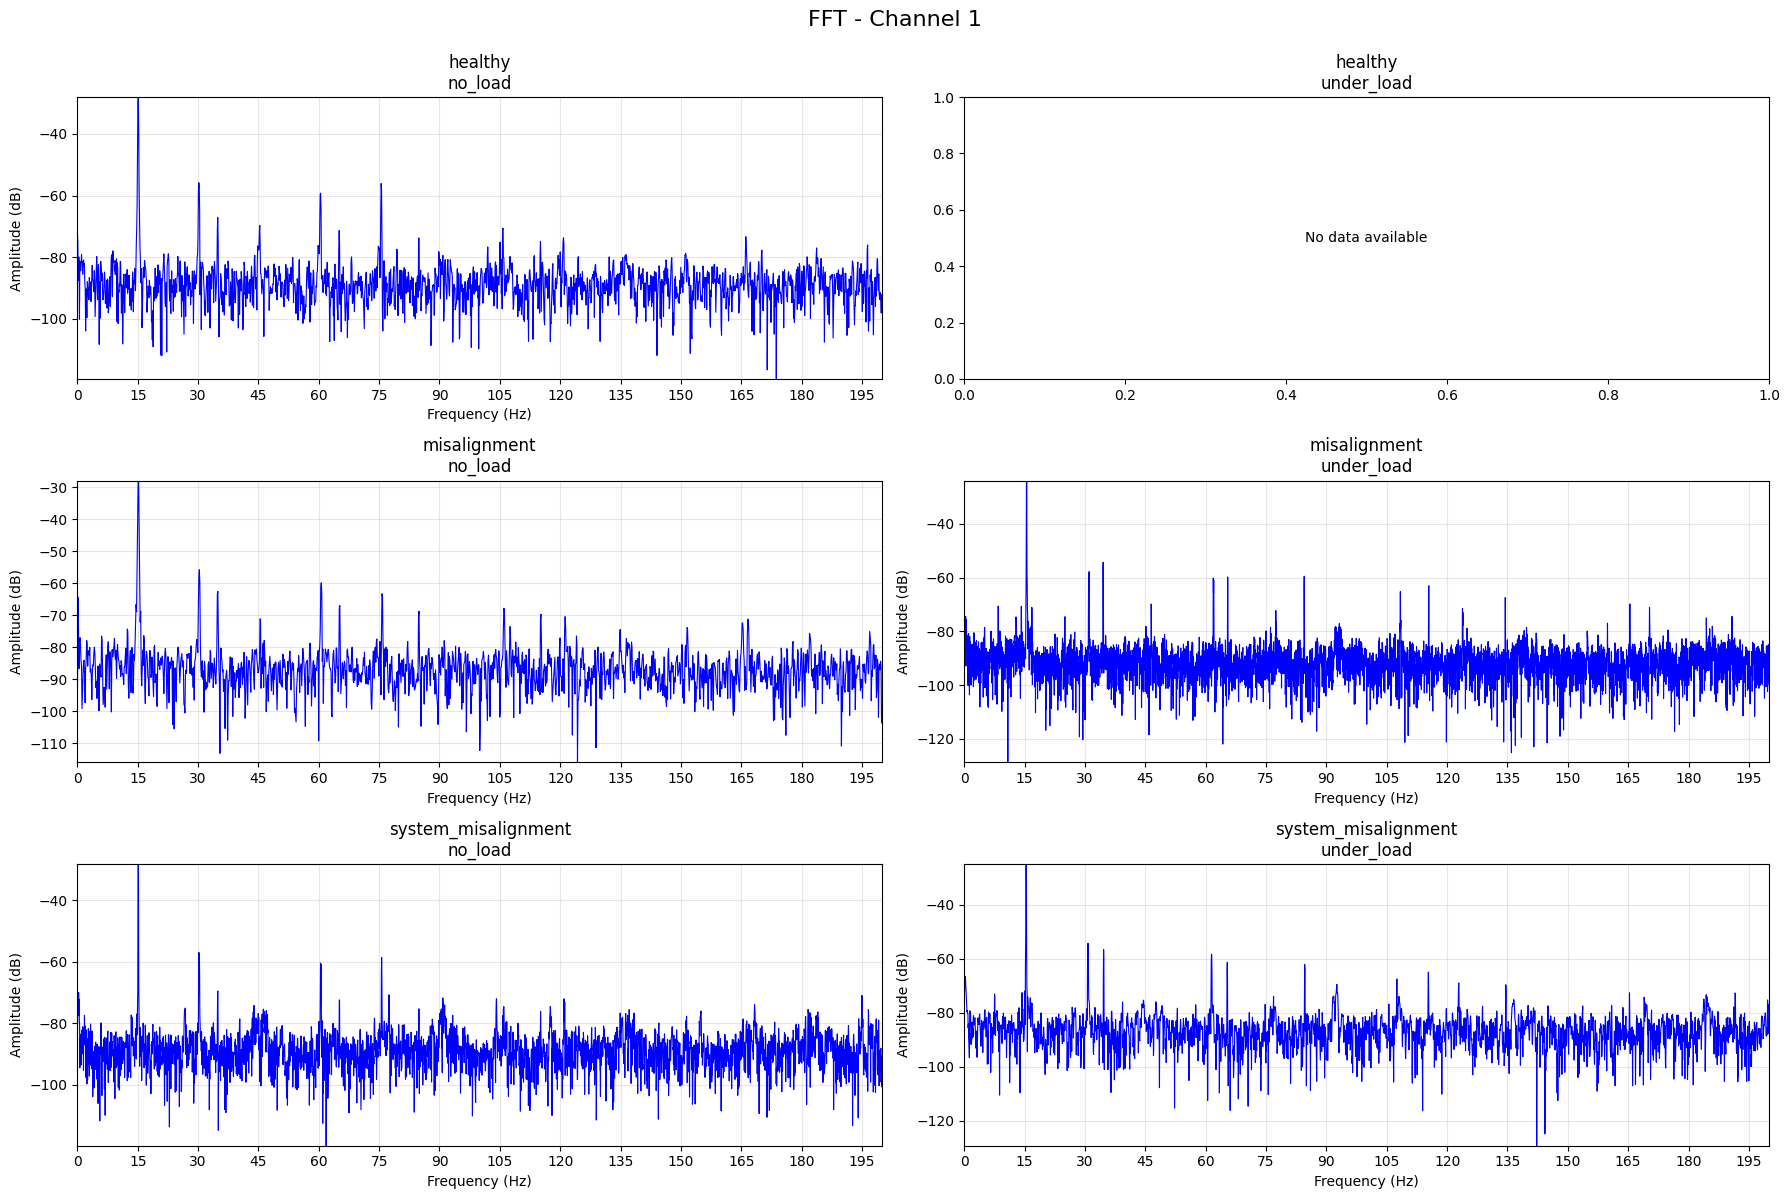

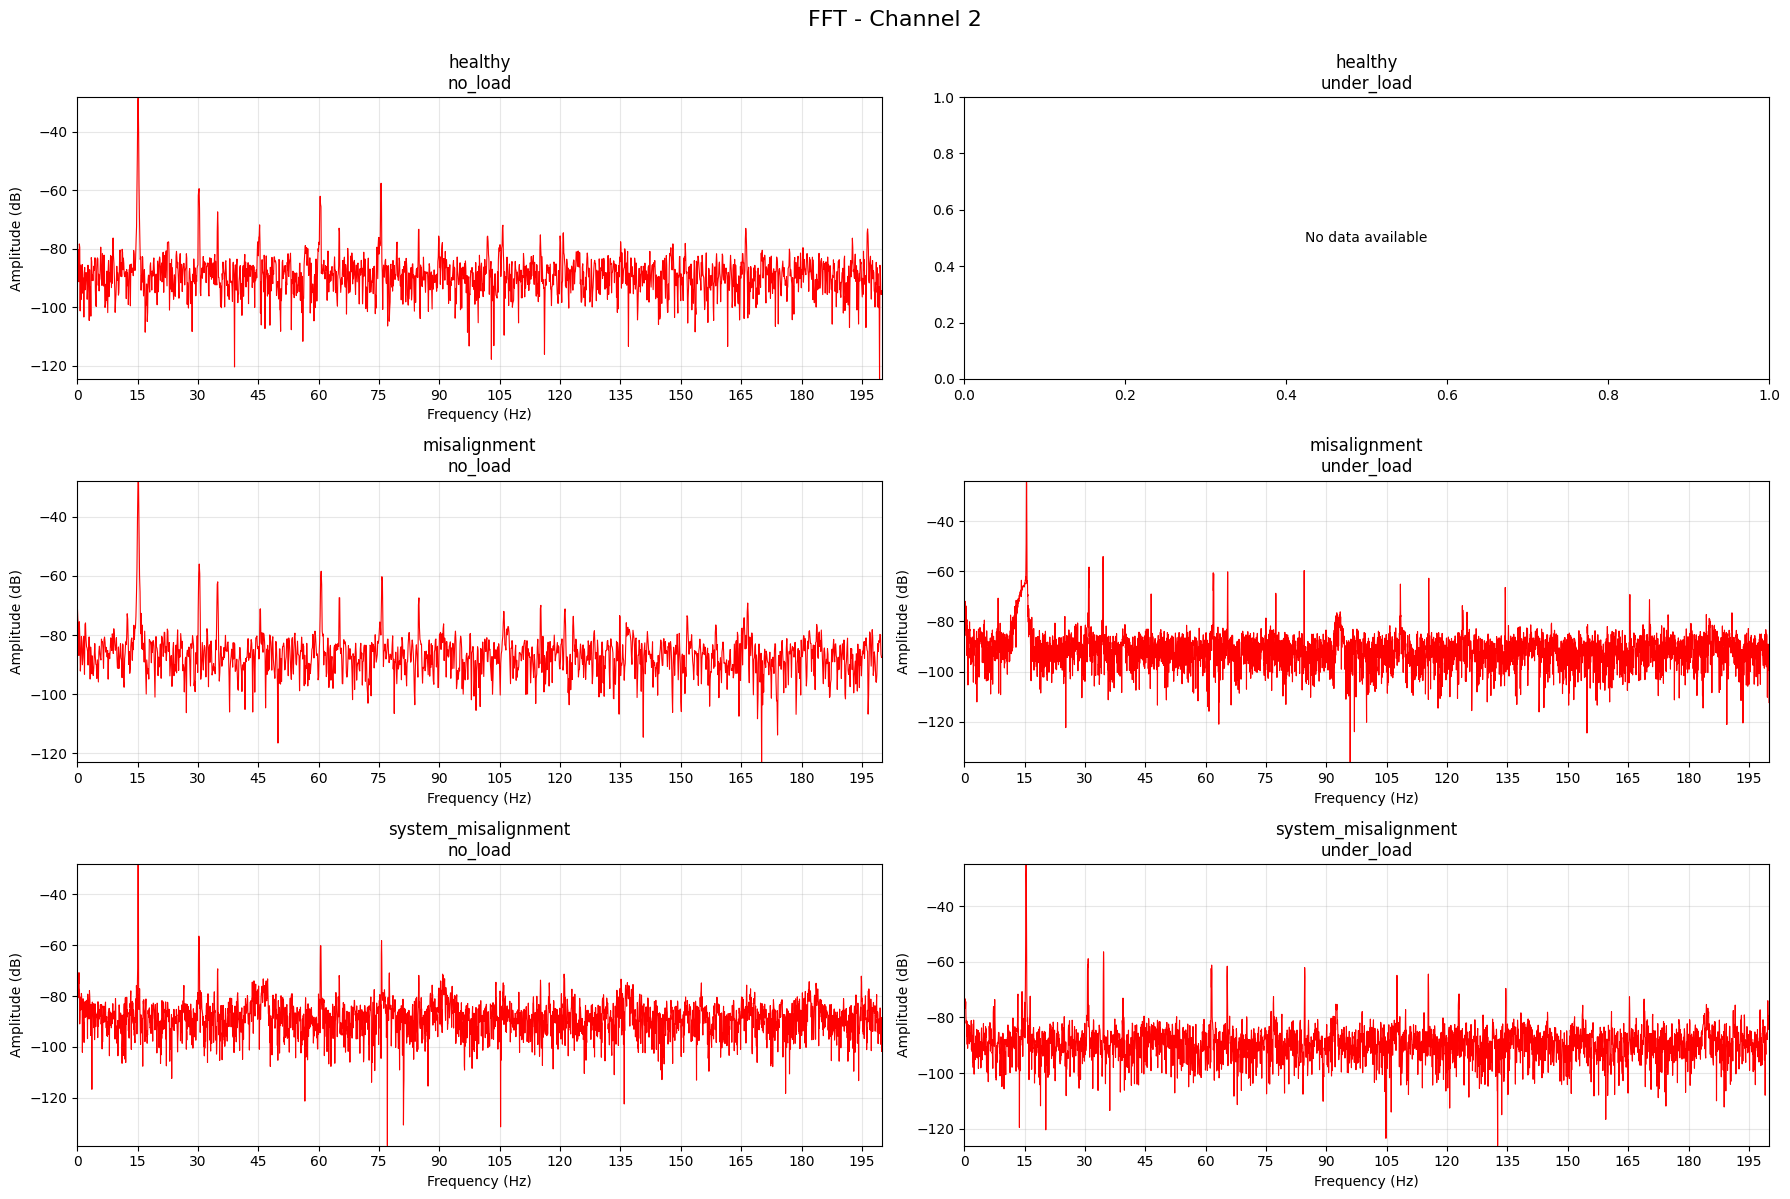


Summary of Peak Amplitudes:
          condition       load  target_freq  peak_freq_ch1  peak_amp_ch1_linear  peak_freq_ch2  peak_amp_ch2_linear
            healthy    no_load           15      15.140820             0.039436      15.140820             0.038694
            healthy    no_load           30      30.179337             0.001616      30.281640             0.001058
            healthy    no_load           60      60.460977             0.001094      60.358674             0.000785
            healthy    no_load           90      89.821891             0.000123      89.821891             0.000164
            healthy    no_load          120     120.819650             0.000207     120.819650             0.000187
            healthy    no_load          150     151.203593             0.000115     151.101290             0.000123
            healthy    no_load          180     183.735895             0.000142     180.359901             0.000104
       misalignment    no_load           15

In [8]:
# Comprehensive FFT Analysis across all conditions and loads
from scipy.fft import fft, fftfreq
from scipy.signal import medfilt, butter, filtfilt, find_peaks, windows

# Define conditions and loads to analyze
conditions = ['healthy', 'misalignment', 'system_misalignment']
loads = ['no_load', 'under_load']
frequency = '30hz'
target_freqs = [15, 30, 60, 90, 120, 150, 180]
file_idx = 0
xlimval = 200
do_db = True

# Filter setup
sampling_rate = 10000
nyquist = sampling_rate / 2
normal_cutoff = 3500 / nyquist
b, a = butter(4, normal_cutoff, btype='low', analog=False)

def apply_filter(signal):
    """Apply median filter and butterworth lowpass filter"""
    despiked = medfilt(signal, kernel_size=21)
    filtered = filtfilt(b, a, despiked)
    return filtered

def compute_fft_matlab_style(signal, are_u_sure=False):
    """
    Compute FFT with Hann window and MATLAB-style one-sided spectrum normalization.
    Equivalent to MATLAB:
        P2 = abs(fft_result(1:floor(N/2)+1));
        P2(2:end-1) = 2 * P2(2:end-1);
    """
    N = len(signal)
    hann_window = windows.hann(N)
    if are_u_sure:
        # Apply Hann window
        windowed_signal = signal * hann_window

        # Compute FFT with normalization by N 
        fft_result = fft(windowed_signal) / N

        # Get one-sided spectrum (from 0 to Nyquist)
        n_oneside = N // 2 + 1
        fft_oneside = np.abs(fft_result[:n_oneside])

        # MATLAB-style normalization: multiply by 2 except DC (index 0) and Nyquist (last index)
        fft_oneside[1:-1] = 2 * fft_oneside[1:-1]

        # Frequency bins for one-sided spectrum
        freqs_oneside = np.arange(n_oneside) * (sampling_rate / N)
    else:
        
        windowed_signal = signal * hann_window
        fft_ch1 = fft(windowed_signal) / N

        # Frequency bins
        freqs_oneside = fftfreq(len(signal), 1/sampling_rate)

        # Get positive frequencies only
        positive_freq_idx = freqs_oneside >= 0
        freqs_oneside = freqs_oneside[positive_freq_idx]
        fft_oneside = np.abs(fft_ch1[positive_freq_idx])
    
    return freqs_oneside, fft_oneside

def find_peak_amplitude(freqs, fft_linear, fft_db, target_freq, search_window=5):
    """Find peak amplitude near target frequency, return both linear and dB"""
    # Define search range around target frequency
    search_mask = (freqs >= target_freq - search_window) & (freqs <= target_freq + search_window)
    search_freqs = freqs[search_mask]
    search_amps_db = fft_db[search_mask]
    search_amps_linear = fft_linear[search_mask]
    
    if len(search_amps_db) == 0:
        return target_freq, np.nan, np.nan
    
    # Find peaks in the search window (using dB for peak detection)
    peaks, _ = find_peaks(search_amps_db, height=None)
    
    if len(peaks) > 0:
        # Get the highest peak
        max_peak_idx = peaks[np.argmax(search_amps_db[peaks])]
        peak_freq = search_freqs[max_peak_idx]
        peak_amp_db = search_amps_db[max_peak_idx]
        peak_amp_linear = search_amps_linear[max_peak_idx]
    else:
        # No peaks found, use maximum value in window
        max_idx = np.argmax(search_amps_db)
        peak_freq = search_freqs[max_idx]
        peak_amp_db = search_amps_db[max_idx]
        peak_amp_linear = search_amps_linear[max_idx]
    
    return peak_freq, peak_amp_linear, peak_amp_db

# Storage for results
results = []

# Create figures for both channels
n_conditions = len(conditions)
n_loads = len(loads)

fig1, axes1 = plt.subplots(n_conditions, n_loads, figsize=(18, 12))
fig1.suptitle('FFT - Channel 1', fontsize=16, y=0.995)

fig2, axes2 = plt.subplots(n_conditions, n_loads, figsize=(18, 12))
fig2.suptitle('FFT - Channel 2', fontsize=16, y=0.995)

# Process each condition and load
for i, condition in enumerate(conditions):
    for j, load in enumerate(loads):
        try:
            # Load data
            data, metadata = data_loader.load_batch(
                condition=condition,
                load=load,
                sensor_type=sensor_type,
                frequency=frequency,
                apply_filter=False,
                max_workers=1
            )
            
            if len(data) == 0:
                axes1[i, j].text(0.5, 0.5, 'No data available', 
                               ha='center', va='center', transform=axes1[i, j].transAxes)
                axes1[i, j].set_title(f'{condition}\n{load}')
                axes2[i, j].text(0.5, 0.5, 'No data available', 
                               ha='center', va='center', transform=axes2[i, j].transAxes)
                axes2[i, j].set_title(f'{condition}\n{load}')
                continue
            
            # Extract first sample
            sample = data[file_idx]
            sample_meta = metadata[file_idx]
            
            # Extract windows
            window_config = WindowConfig(
                window_size=sample.shape[0],
                step_size=int(sample.shape[0] * 0.5),
                overlap_ratio=0.5
            )
            extractor = WindowExtractor(window_config)
            windows_data, _ = extractor.extract_windows(sample, sample_meta)
            
            # Get first window
            window = windows_data[0]
            ch1 = window[:, 0]
            ch2 = window[:, 1]
            
            # Apply filtering
            #ch1 = apply_filter(ch1)
            #ch2 = apply_filter(ch2)
            
            # Compute FFT with Hann window and MATLAB-style normalization
            freqs_pos, fft_ch1_pos = compute_fft_matlab_style(ch1)
            _, fft_ch2_pos = compute_fft_matlab_style(ch2)
            
            fft_ch1_db = fft_ch1_pos
            fft_ch2_db = fft_ch2_pos
            # Convert to dB
            if do_db:
                fft_ch1_db = 20 * np.log10(fft_ch1_pos + 1e-10)
                fft_ch2_db = 20 * np.log10(fft_ch2_pos + 1e-10)

            # Crop arrays to xlimval for better y-axis scaling
            xlim_mask = freqs_pos <= xlimval
            freqs_cropped = freqs_pos[xlim_mask]
            fft_ch1_cropped = fft_ch1_db[xlim_mask]
            fft_ch2_cropped = fft_ch2_db[xlim_mask]

            # Plot FFT for Channel 1
            axes1[i, j].plot(freqs_cropped, fft_ch1_cropped, 'b-', linewidth=0.8)
            axes1[i, j].set_xlabel('Frequency (Hz)')
            axes1[i, j].set_ylabel('Amplitude (dB)')
            axes1[i, j].set_title(f'{condition}\n{load}')
            axes1[i, j].grid(True, alpha=0.3)
            axes1[i, j].set_xlim(0, xlimval)
            axes1[i, j].set_ylim(min(fft_ch1_cropped), max(fft_ch1_cropped))
            axes1[i, j].set_xticks(np.arange(0, xlimval + 1, 15))
            
            # Plot FFT for Channel 2
            axes2[i, j].plot(freqs_cropped, fft_ch2_cropped, 'r-', linewidth=0.8)
            axes2[i, j].set_xlabel('Frequency (Hz)')
            axes2[i, j].set_ylabel('Amplitude (dB)')
            axes2[i, j].set_title(f'{condition}\n{load}')
            axes2[i, j].grid(True, alpha=0.3)
            axes2[i, j].set_xlim(0, xlimval)
            axes2[i, j].set_ylim(min(fft_ch2_cropped), max(fft_ch2_cropped))
            axes2[i, j].set_xticks(np.arange(0, xlimval + 1, 15))
            
            # Find peak amplitudes at target frequencies
            for target_freq in target_freqs:
                peak_freq_ch1, peak_amp_ch1_lin, peak_amp_ch1_db = find_peak_amplitude(
                    freqs_pos, fft_ch1_pos, fft_ch1_db, target_freq)
                peak_freq_ch2, peak_amp_ch2_lin, peak_amp_ch2_db = find_peak_amplitude(
                    freqs_pos, fft_ch2_pos, fft_ch2_db, target_freq)
                
                # Store results
                results.append({
                    'condition': condition,
                    'load': load,
                    'target_freq': target_freq,
                    'peak_freq_ch1': peak_freq_ch1,
                    'peak_amp_ch1_linear': peak_amp_ch1_lin,
                    'peak_freq_ch2': peak_freq_ch2,
                    'peak_amp_ch2_linear': peak_amp_ch2_lin,
                })
            
        except Exception as e:
            axes1[i, j].text(0.5, 0.5, f'Error: {str(e)[:30]}...', 
                           ha='center', va='center', transform=axes1[i, j].transAxes)
            axes1[i, j].set_title(f'{condition}\n{load}')
            axes2[i, j].text(0.5, 0.5, f'Error: {str(e)[:30]}...', 
                           ha='center', va='center', transform=axes2[i, j].transAxes)
            axes2[i, j].set_title(f'{condition}\n{load}')

fig1.tight_layout()
fig2.tight_layout()
plt.show()

# Create summary DataFrame
results_df = pd.DataFrame(results)
print("\nSummary of Peak Amplitudes:")
print("="*150)
print(results_df.to_string(index=False))

# Export to Excel
output_path = Path("../reports/peak_amplitudes_summary.xlsx")
output_path.parent.mkdir(parents=True, exist_ok=True)
results_df.to_excel(output_path, index=False, sheet_name='Peak Amplitudes')
